In [1]:
import tensorflow as tf
import efficientnet.tfkeras as efn
import re
import numpy as np
import random
import ast
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
# from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tf_explain.callbacks.grad_cam import GradCAMCallback
import tensorflow_addons as tfa
from TPUDataLoader import DataLoader
import cv2
tf.random.set_seed(2020)

In [2]:
# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='smas255')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Initializing the TPU system: smas255


INFO:tensorflow:Initializing the TPU system: smas255


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [9]:
FLAGS ={}
# Configuration
FLAGS['FOLD']='0'
FLAGS['W'] = 300
FLAGS['H'] = 300
FLAGS['EPOCHS'] = 60
FLAGS['LR'] = 0.00005
FLAGS['WEIGHT_DECAY']=1e-4
FLAGS['BATCH_SIZE'] = 256 * strategy.num_replicas_in_sync
FLAGS['VAL_BATCH_SIZE'] = 128
FLAGS['GCS_PATH'] = 'gs://deepfake_images/TFRecords/ratio1/landmark/'
FLAGS['GCS_LOGS'] = 'gs://deepfake_images/trainingLogs/'
FLAGS['TRAINING_FILENAMES'] = tf.io.gfile.glob(FLAGS['GCS_PATH'] + 'fold{}/train/*.tfrec'.format(FLAGS['FOLD']))
FLAGS['VALIDATION_FILENAMES'] = tf.io.gfile.glob(FLAGS['GCS_PATH'] + 'fold{}/val/*.tfrec'.format(FLAGS['FOLD']))
FLAGS['TEST_FILENAMES'] = tf.io.gfile.glob(FLAGS['GCS_PATH'] + 'test/*.tfrec')

random.shuffle(FLAGS['TRAINING_FILENAMES'])


In [10]:
dataLoader = DataLoader(FLAGS)

In [11]:
# img_list = []
# lbl_list = []
# for img,lbl in dataLoader.get_gradcam_dataset():
#     img_list = img.numpy()
#     lbl_list = lbl.numpy()
#     break
# np.save('./data/img.npy',img_list)
# np.save('./data/lbl.npy',lbl_list)

In [12]:
# img_list = np.load('./data/img.npy')
# lbl_list = np.load('./data/lbl.npy')

In [13]:
def efficientAttention():
    in_lay = Input(shape=(FLAGS['H'],FLAGS['W'],3))
    base_model = efn.EfficientNetB3(
        input_shape=( FLAGS['H'],FLAGS['W'], 3),
        weights='noisy-student',
        include_top=False
    )
    pt_depth = base_model.get_output_shape_at(0)[-1]
    pt_features = base_model(in_lay)
    bn_features = BatchNormalization()(pt_features)
    # here we do an attention mechanism to turn pixels in the GAP on an off
    attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
    attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
    attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
    attn_layer = Conv2D(1, 
                        kernel_size = (1,1), 
                        padding = 'valid', 
                        activation = 'sigmoid')(attn_layer)
    # fan it out to all of the channels
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
                   activation = 'linear', use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)

    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = Dropout(0.25)(gap)
    dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
    out_layer = Dense(1, activation = 'sigmoid')(dr_steps)
    model = tf.keras.Model(inputs = [in_lay], outputs = [out_layer])
    return model

In [14]:
def efficientModel(weights_path=None):
    enet = efn.EfficientNetB0(
        input_shape=( FLAGS['H'],FLAGS['W'], 3),
        weights='noisy-student',
        include_top=False,
        pooling = 'avg'
    )
    #output = tf.keras.layers.GlobalAveragePooling2D()(enet.output)
    #output = tf.keras.layers.Dropout(0.2)(enet.output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(enet.output)
    model = tf.keras.Model(inputs=enet.input, outputs=output)
    if weights_path!=None:
        model.load_weights(weights_path)
    return model

In [15]:
def resnet():
    res = Xception(weights='imagenet', include_top=False)
   
    output = tf.keras.layers.GlobalAveragePooling2D()(res.output)
    #output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    model = tf.keras.Model(inputs=res.input, outputs=output)
    return model

In [16]:
with strategy.scope():
    model = efficientAttention()

## Warm up

In [17]:
FLAGS['NUM_TRAINING_IMAGES'] = dataLoader.count_data_items(FLAGS['TRAINING_FILENAMES'])
FLAGS['NUM_VALIDATION_IMAGES'] = dataLoader.count_data_items(FLAGS['VALIDATION_FILENAMES'])
FLAGS['STEPS_PER_EPOCH'] = FLAGS['NUM_TRAINING_IMAGES'] // FLAGS['BATCH_SIZE']
FLAGS['VALIDATION_STEPS'] = FLAGS['NUM_VALIDATION_IMAGES'] // FLAGS['VAL_BATCH_SIZE']
print('Dataset: {} training images, {} validation images, {} Steps'.format(
    FLAGS['NUM_TRAINING_IMAGES'], FLAGS['NUM_VALIDATION_IMAGES'],FLAGS['STEPS_PER_EPOCH']))

Dataset: 348162 training images, 81958 validation images, 170 Steps


In [18]:
# warm up model
for layer in model.layers:
    layer.trainable = False

for i in range(-15,0):
    model.layers[i].trainable = True
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        #loss=macro_double_soft_f1,
        #optimizer=tf.keras.optimizers.SGD(learning_rate= FLAGS['LR'],momentum=0.9,decay=FLAGS['WEIGHT_DECAY']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
model.fit(
    dataLoader.get_training_dataset(), 
    steps_per_epoch=FLAGS['STEPS_PER_EPOCH'],
    epochs=1)

Train for 170 steps
170/170 [==============================] - 1460s 9s/step - loss: 0.6615 - accuracy: 0.5864


## Train Model

In [ ]:
for layer in model.layers:
    layer.trainable = True
radam = tfa.optimizers.RectifiedAdam(lr=FLAGS['LR'])
opt = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
 
model.compile(
        optimizer=opt,#tf.keras.optimizers.Adam(lr=FLAGS['LR'], clipnorm=1.),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
#lr_schedule = OneCycleScheduler(FLAGS['LR'], FLAGS['STEPS_PER_EPOCH'])
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, 
                                   verbose=1, mode='auto', min_delta=0.0001)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=FLAGS['GCS_LOGS'], update_freq=10)
# gradcam_callback = GradCAMCallback(
#         validation_data=(img_list,lbl_list),
#         layer_name="top_conv",
#         class_index=0,
#         output_dir=FLAGS['GCS_LOGS']
#     )
#lr_schedule = OneCycleScheduler(FLAGS['LR'], FLAGS['STEPS_PER_EPOCH'])
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='gs://hamid_kaggles/model_checkpoints/',
                                                 monitor='val_loss',
                                                 verbose=1,
                                                 save_best_only=True,
                                                 save_weights_only=True
                                                 )
history = model.fit(
    dataLoader.get_training_dataset(), 
    steps_per_epoch=FLAGS['STEPS_PER_EPOCH'],
    epochs=FLAGS['EPOCHS'], 
    callbacks=[lr_schedule,cp_callback],
    validation_data=dataLoader.get_validation_dataset())

Train for 170 steps
Epoch 1/60
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


169/170 [============================>.] - ETA: 8s - loss: 0.6854 - accuracy: 0.5521 
Epoch 00001: val_loss improved from inf to 0.65890, saving model to gs://hamid_kaggles/model_checkpoints/
170/170 [==============================] - 1890s 11s/step - loss: 0.6853 - accuracy: 0.5523 - val_loss: 0.6589 - val_accuracy: 0.6225
Epoch 2/60
169/170 [============================>.] - ETA: 4s - loss: 0.6546 - accuracy: 0.6012
Epoch 00002: val_loss improved from 0.65890 to 0.59952, saving model to gs://hamid_kaggles/model_checkpoints/
170/170 [==============================] - 753s 4s/step - loss: 0.6544 - accuracy: 0.6015 - val_loss: 0.5995 - val_accuracy: 0.6633
Epoch 3/60
169/170 [============================>.] - ETA: 5s - loss: 0.6121 - accuracy: 0.6472 
Epoch 00003: val_loss improved from 0.59952 to 0.53821, saving model to gs://hamid_kaggles/model_checkpoints/
170/170 [==============================] - 946s 6s/step - loss: 0.6120 - accuracy: 0.6474 - val_loss: 0.5382 - val_accuracy: 0.70

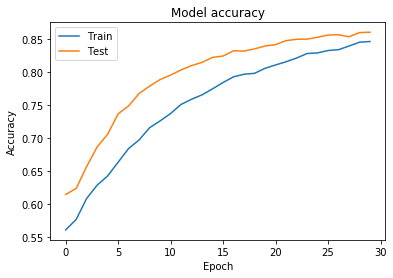

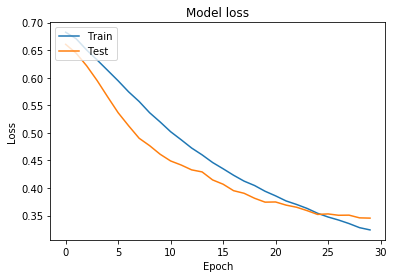

In [14]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
model.save_weights('./b1.h5')

## Test Model

In [ ]:
with strategy.scope():
    model = efficientModel()
    model.load_weights('gs://hamid_kaggles/model_checkpoints/')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=FLAGS['LR'], clipnorm=1.),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [16]:
FLAGS['NUM_TEST_IMAGES'] = dataLoader.count_data_items(FLAGS['TEST_FILENAMES'])

FLAGS['TEST_STEPS_PER_EPOCH'] = FLAGS['NUM_TEST_IMAGES'] // FLAGS['BATCH_SIZE']


In [17]:
results = model.evaluate(dataLoader.get_test_dataset(), 
    steps=FLAGS['TEST_STEPS_PER_EPOCH'],)

7/7 [==============================] - 10s 1s/step - loss: 0.4663 - accuracy: 0.9107


In [12]:
!wget https://tpu.googleapis.com/v1/projects/deepfake-267708/locations/europe-west4-a/nodes/tpu-32?alt=json

--2020-03-08 02:48:41--  https://tpu.googleapis.com/v1/projects/deepfake-267708/locations/europe-west4-a/nodes/tpu-32?alt=json
Resolving tpu.googleapis.com (tpu.googleapis.com)... 108.177.119.95, 2a00:1450:4013:c04::5f
Connecting to tpu.googleapis.com (tpu.googleapis.com)|108.177.119.95|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-03-08 02:48:41 ERROR 403: Forbidden.



In [14]:
!python deepfake_training.py

2020-03-17 00:55:59.249643: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2020-03-17 00:55:59.249754: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2020-03-17 00:55:59.249779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2020-03-17 00:56:00.731180: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-03-17 00:56:00.731232: E tensorflow/stream_executor/cuda

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):


    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')